In [10]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd
from scipy.stats import entropy, norm

In [11]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

def normalize_01(record):
    max_val = np.max(record, axis=-1)
    min_val = np.min(record, axis=-1)
    normalized_data = (record.T - min_val) / (max_val - min_val + 0.0008)

    return normalized_data.T

def normalize_std(record):
    mean_val = np.mean(record, axis=-1)
    std_val = np.std(record, axis=-1)
    normalized = (record.T - mean_val) / std_val

    return normalized.T

def JS_divergence(p, q):

    p = normalize_01(p)
    q = normalize_01(q)
    
    M = (p + q) / 2
    return 0.5 * entropy(p, M, base=2) + 0.5 * entropy(q, M, base=2)

def total_variation_distance(p, q):

    p = normalize_01(p)
    q = normalize_01(q)
    
    if len(p) != len(q):
        raise ValueError("两个序列的长度必须相同")

    total_var_distance = 0
    n = len(p)

    for i in range(n):
        total_var_distance += abs(p[i] - q[i]) / 2
    total_var_distance /= n

    return total_var_distance

def mean_squared_error(p, q):
    if len(p) != len(q):
        raise ValueError("两个序列的长度必须相同")

    mse = sum((pi - qi) ** 2 for pi, qi in zip(p, q)) / len(p)
    
    return mse

def compute_cdf(values):
    # 使用SciPy中的norm库估计累积分布函数
    cdf_values = norm.cdf(values)
    return cdf_values

def new_CRPS(target, sample):
    true_cdf = compute_cdf(target)
    gen_cdf = compute_cdf(sample)
        
    crps_i = np.sum(np.square(true_cdf - gen_cdf))
    return crps_i

def compute_nrmse(target_sequence, predicted_sequence):
    # 计算均方根误差（RMSE）
    rmse = np.sqrt(np.mean((target_sequence - predicted_sequence) ** 2))

    # 将RMSE标准化
    amplitude_range = np.max(target_sequence) - np.min(target_sequence)
    if amplitude_range == 0:
        return None
    nrmse = rmse / amplitude_range

    return nrmse

def index_clipping(x):
    x = np.array(x)
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    filtered_data = x[(x >= Q1 - 1.5 * IQR) & (x <= Q3 + 1.5 * IQR)]

    return filtered_data

In [12]:
path = 'experiments/newtraffic-nj_0225_210039/'
target = np.load(path + "data_save/target.npz")['tar_traffic']
generate = np.load(path + "data_save/generate.npz")['gen_traffic']
datatype = np.load(path + "data_save/datatype.npz")['datatype']

typelist = np.unique(datatype)
indices = {value: np.where(datatype == value)[0] for value in typelist}

In [13]:
pred_len = 48

In [14]:
save_tar = []
save_gen = []
L = target.shape[-1]

for type, list_i in indices.items():
    save_tar_i = []
    save_gen_i = []
    for i in list_i:
        save_tar_i.append(target[i])
        save_gen_i.append(generate[i])
    save_tar_i = np.array(save_tar_i).reshape(-1, 64)
    save_gen_i = np.array(save_gen_i).reshape(-1, 64)
    shape_base = save_tar_i.shape

    path_cache = path + 'scalers/scaler_' + type + '.pk'
    with open(path_cache, "rb") as f:
        scaler = pickle.load(f)

    save_tar_i = save_tar_i.reshape(-1, L)
    save_gen_i = save_gen_i.reshape(-1, L)

    save_gen_i = np.concatenate((save_gen_i[:, :L - pred_len], scaler.inverse_transform(save_gen_i[:, L - pred_len:].reshape(-1, 1)).reshape(-1, pred_len)), axis=-1)

    save_tar.append(save_tar_i)
    save_gen.append(save_gen_i)    

**效果分析**

指标计算

In [15]:
obs = 0

In [16]:
print(typelist[obs])

JS = []
TV_avg = []
CRPS = []
NRMSE = []

N = save_gen[obs].shape[0]
for i in range(N):
    JS_i = JS_divergence(save_tar[obs][i, L - pred_len:], save_gen[obs][i, L - pred_len:])
    TV_avg_i = total_variation_distance(save_tar[obs][i, L - pred_len:], save_gen[obs][i, L - pred_len:])
    NRMSE_i = compute_nrmse(save_tar[obs][i, L - pred_len:], save_gen[obs][i, L - pred_len:])

    if True not in [np.isnan(np.float32(JS_i)).any(), np.isnan(np.float32(TV_avg_i)).any(), np.isnan(np.float32(NRMSE_i)).any()]:
        JS.append(JS_i)
        TV_avg.append(TV_avg_i)
        NRMSE.append(NRMSE_i)

# JS = index_clipping(JS)
# TV_avg = index_clipping(TV_avg)
# NRMSE = index_clipping(NRMSE)

print(f'JS-div: {np.mean(JS):.4g}\t')
print(f'Avg-TV: {np.mean(TV_avg):.4g} \t')
print(f'NRMSE: {np.mean(NRMSE):.4g} \t')

newtraffic-nj
JS-div: 0.03918	
Avg-TV: 0.07628 	
NRMSE: 0.1754 	


In [17]:
np.savez('./save-fs-6-256/long_prediction_FOMO_fs10_newtraffic-nj.npz', gen=save_gen[obs], tar=save_tar[obs])

单个图像（合并nsample）

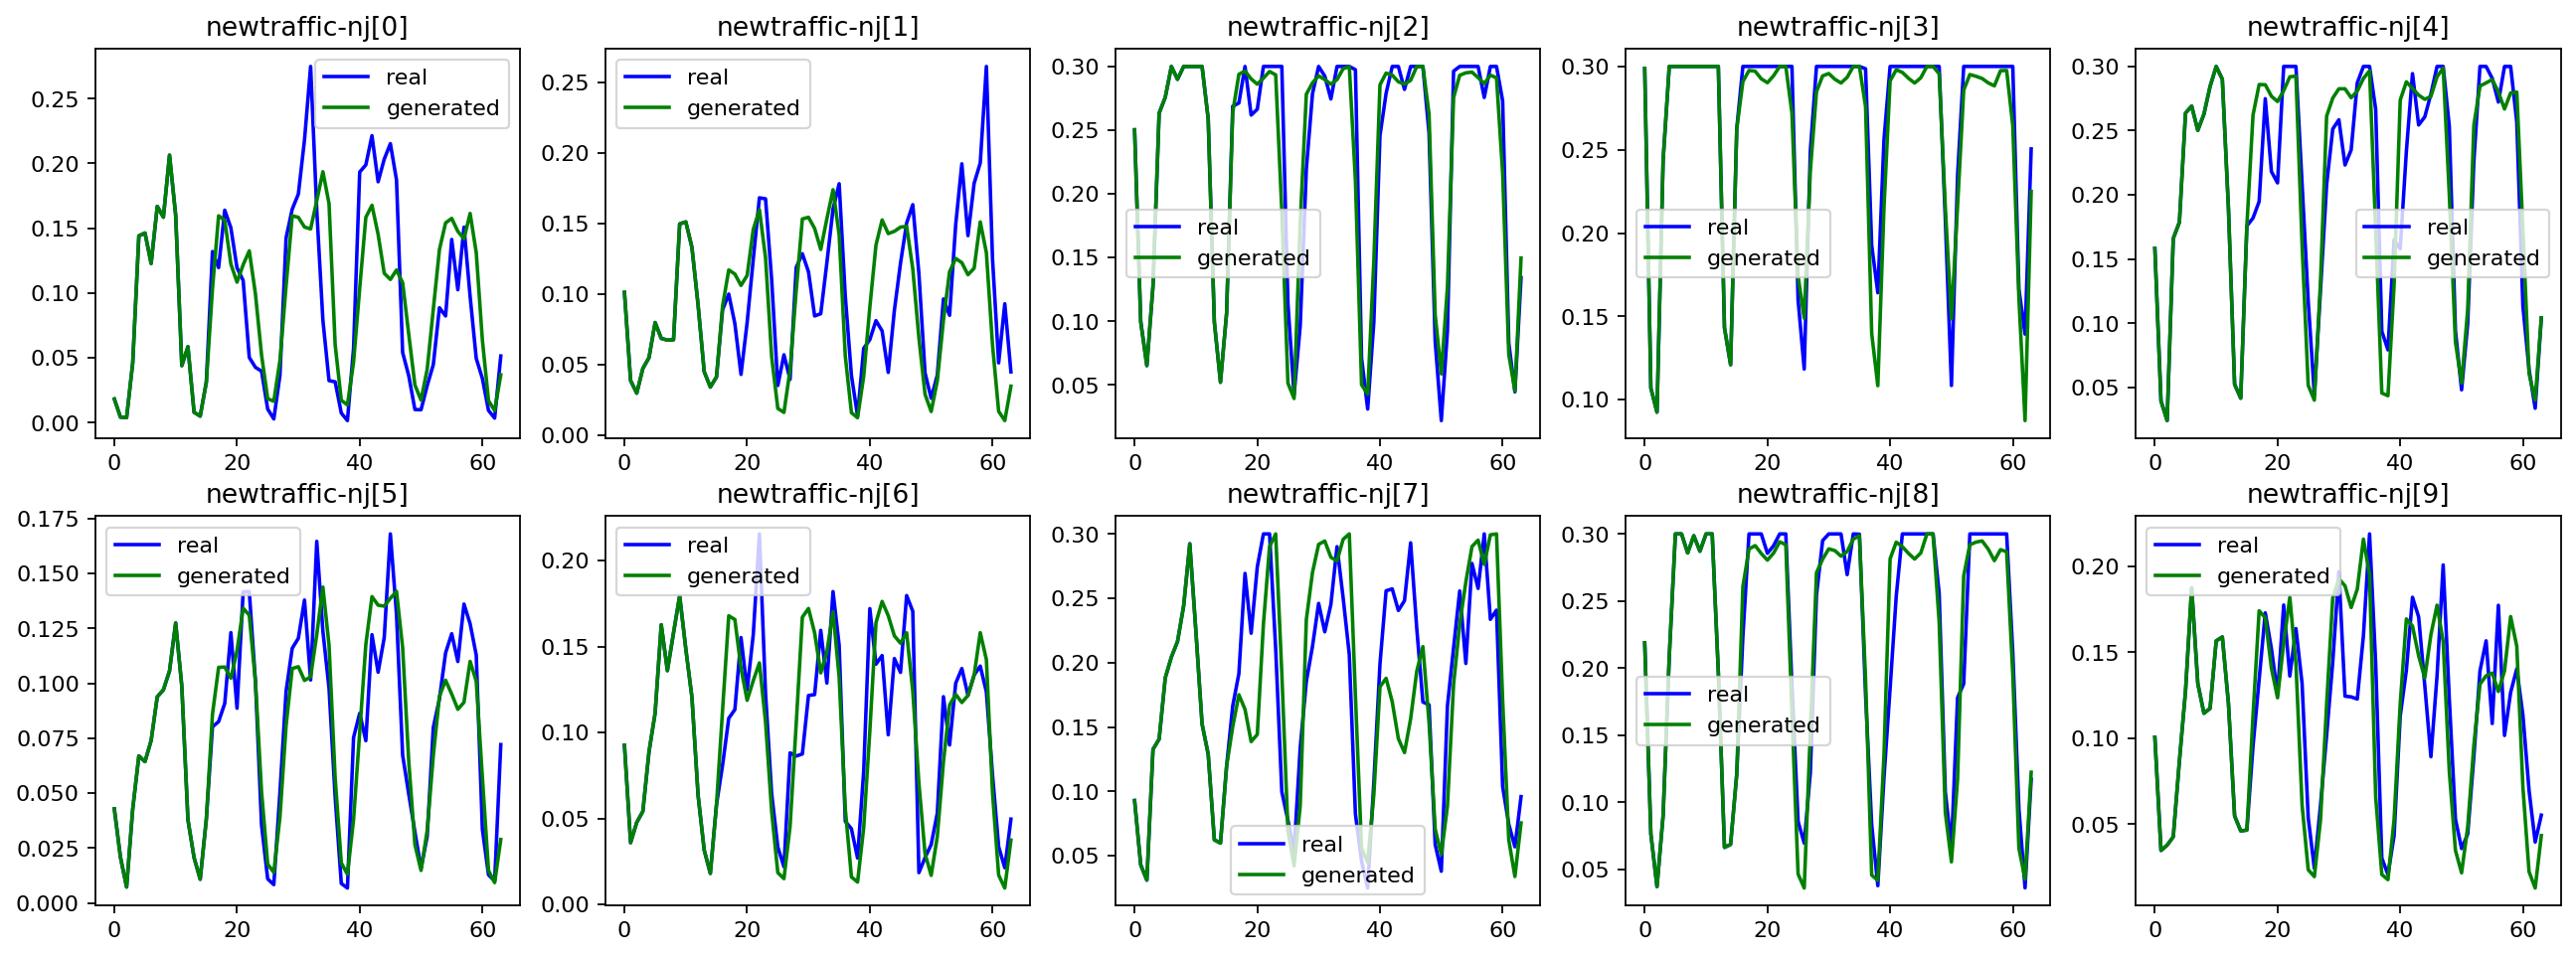

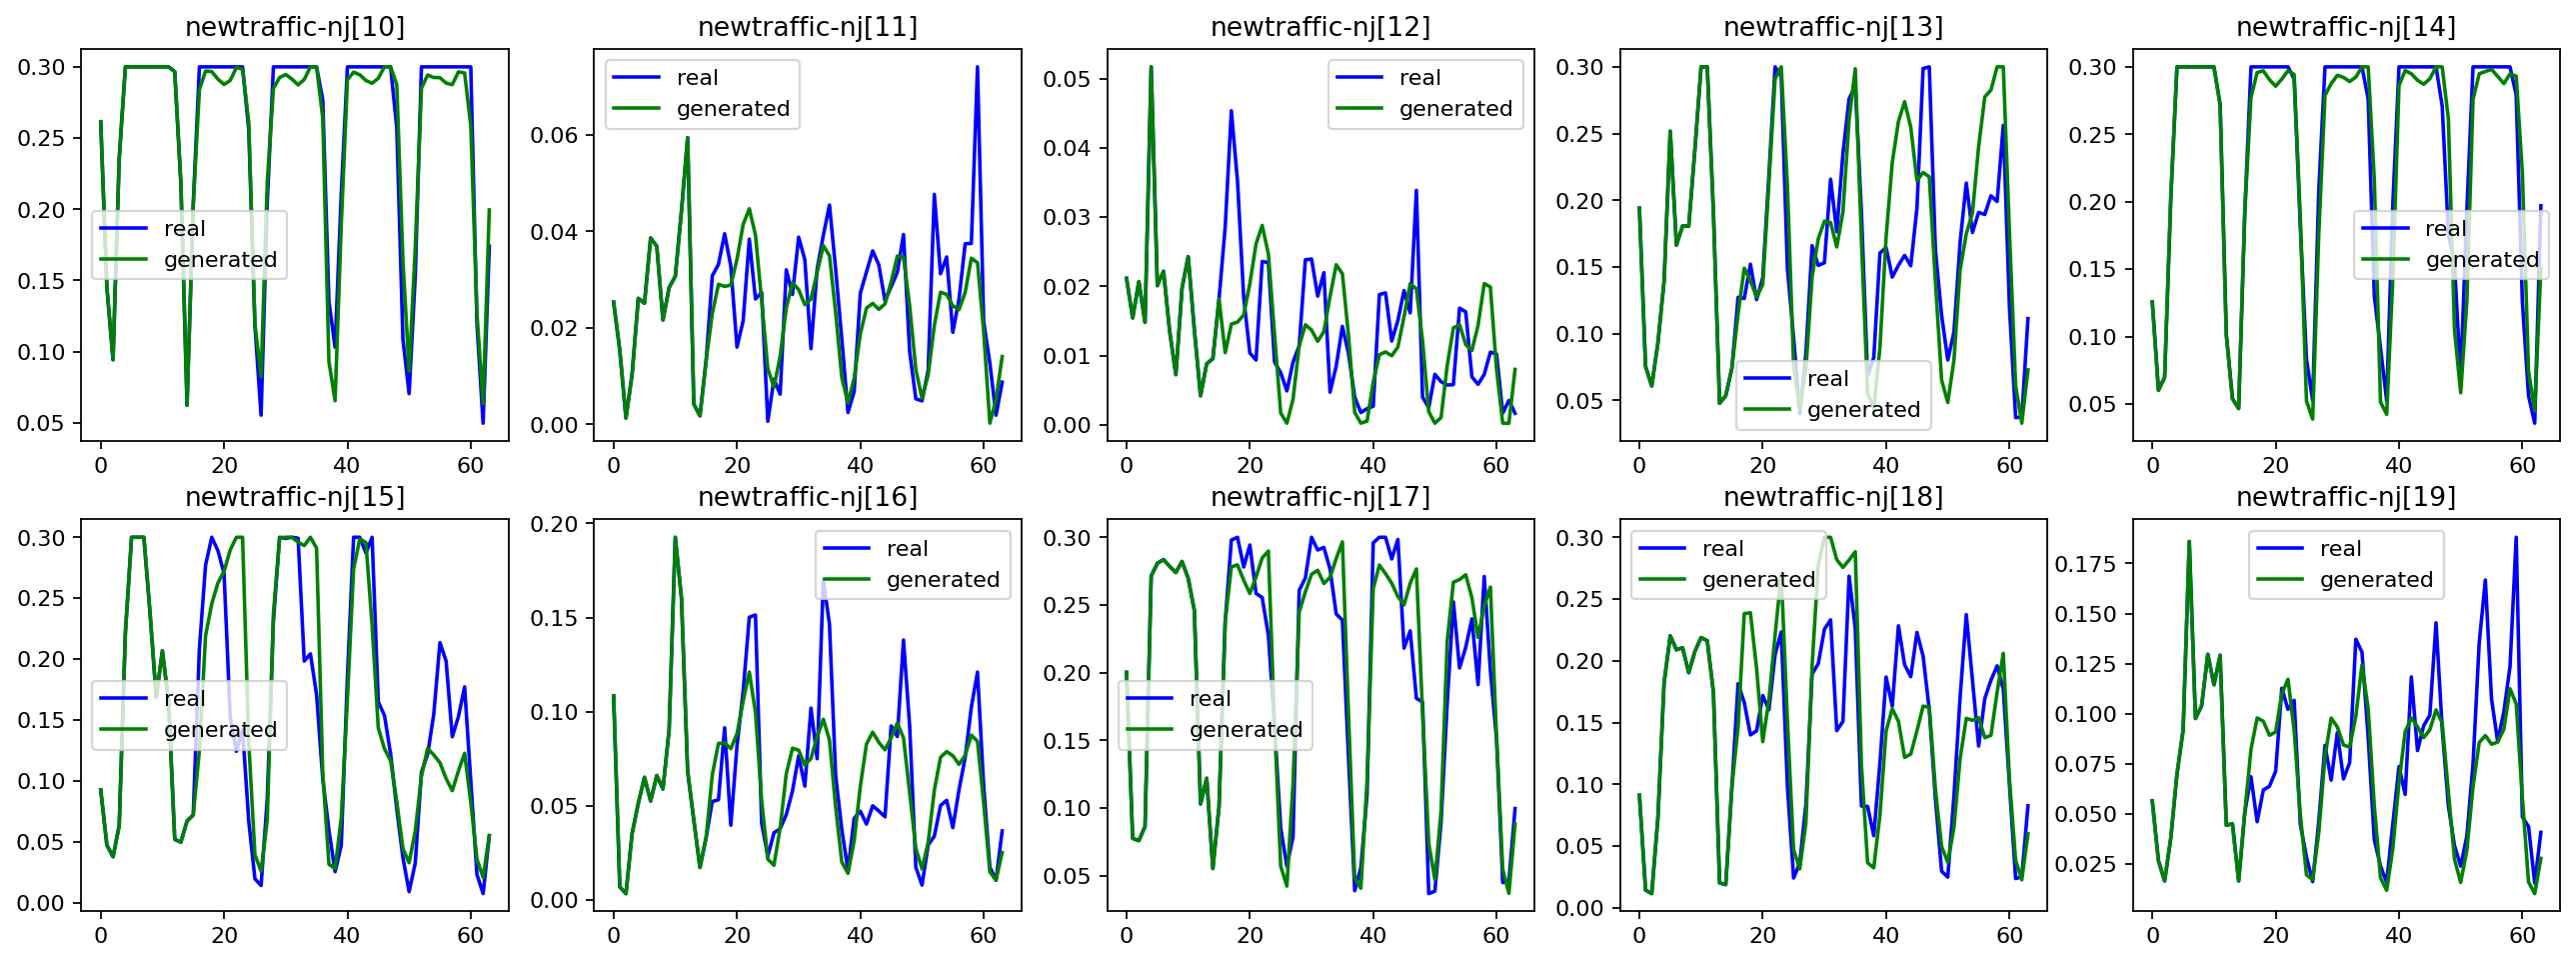

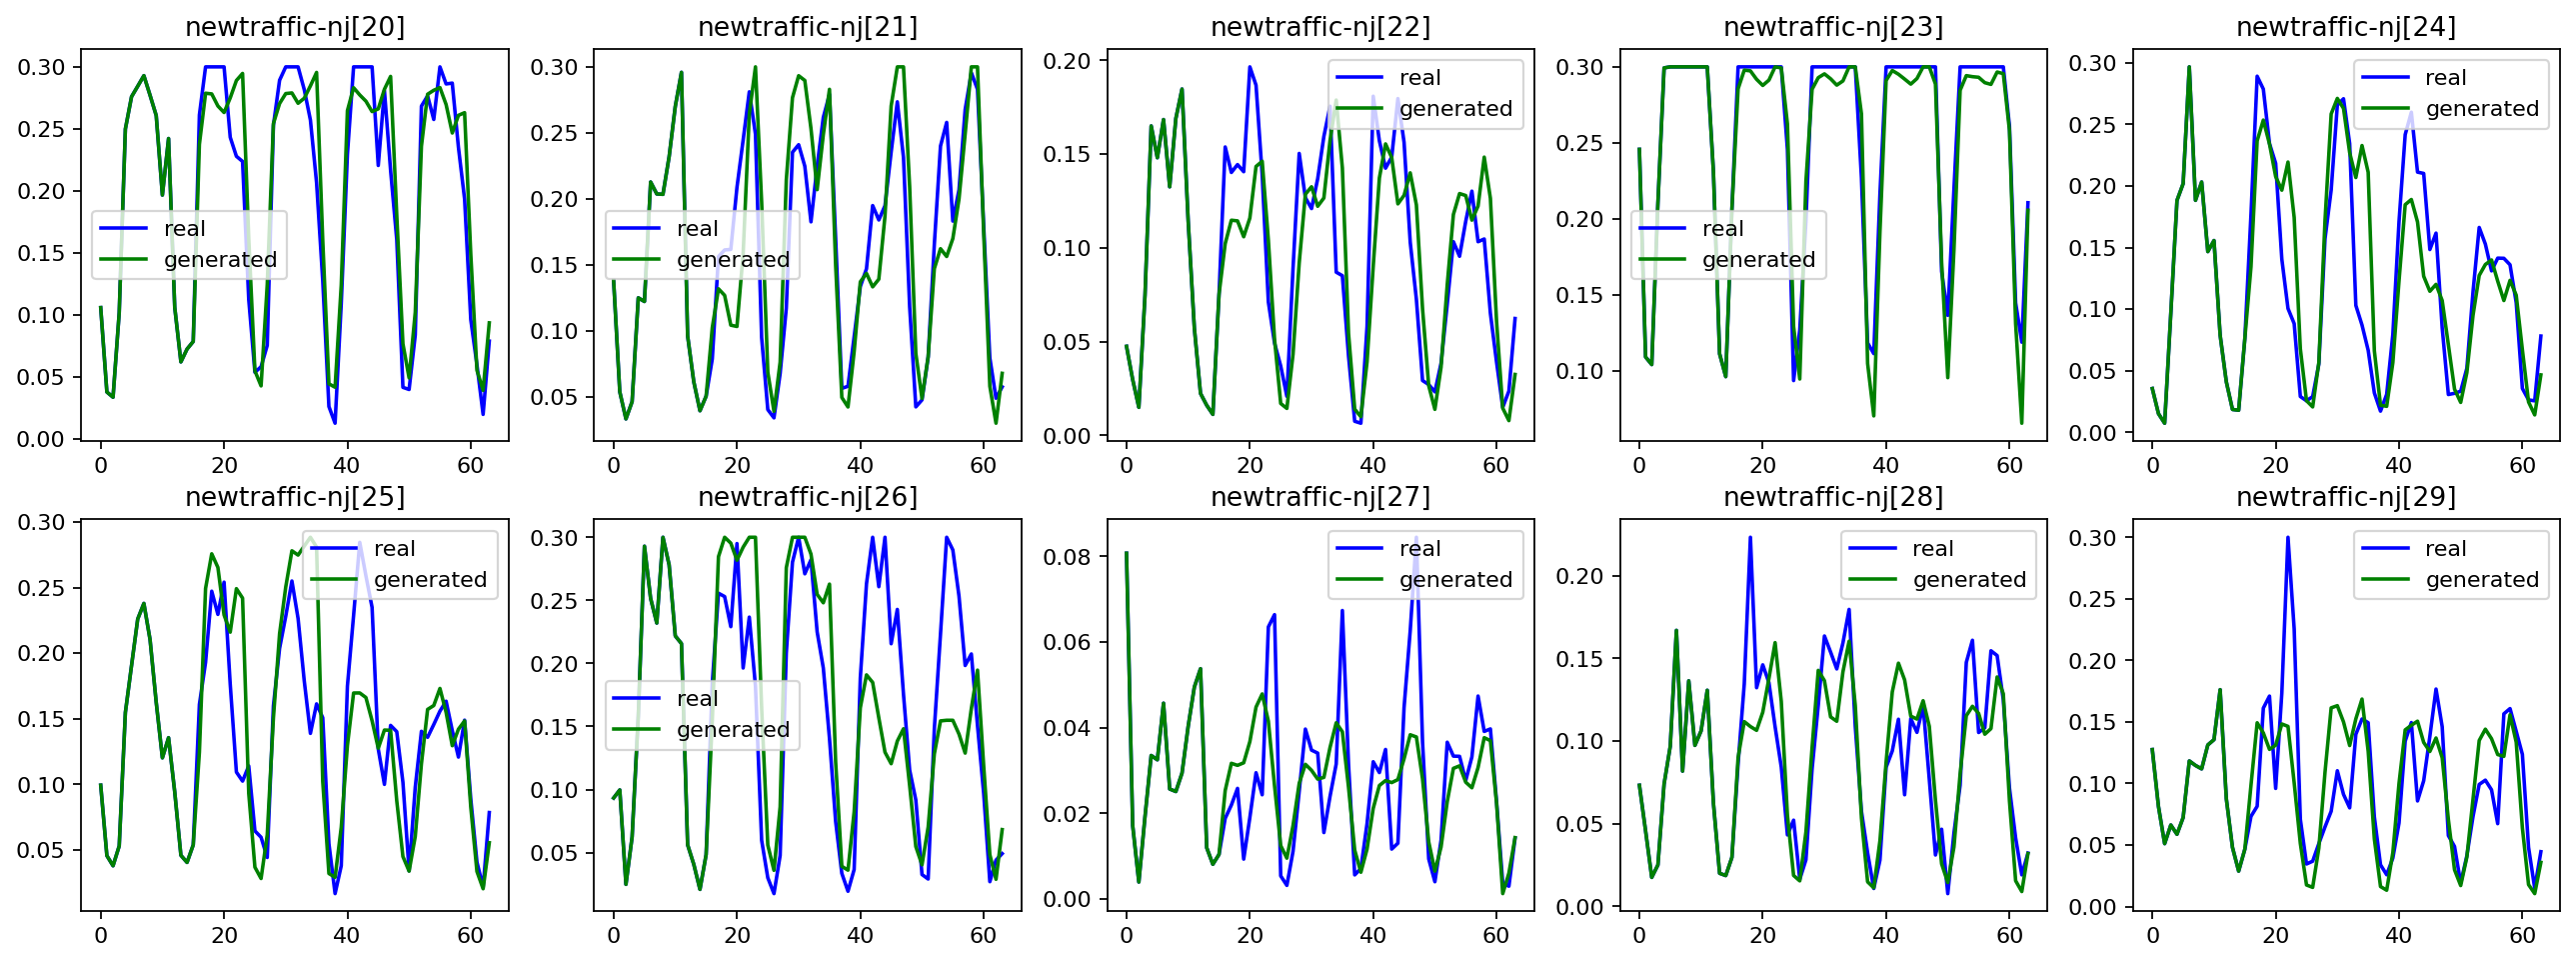

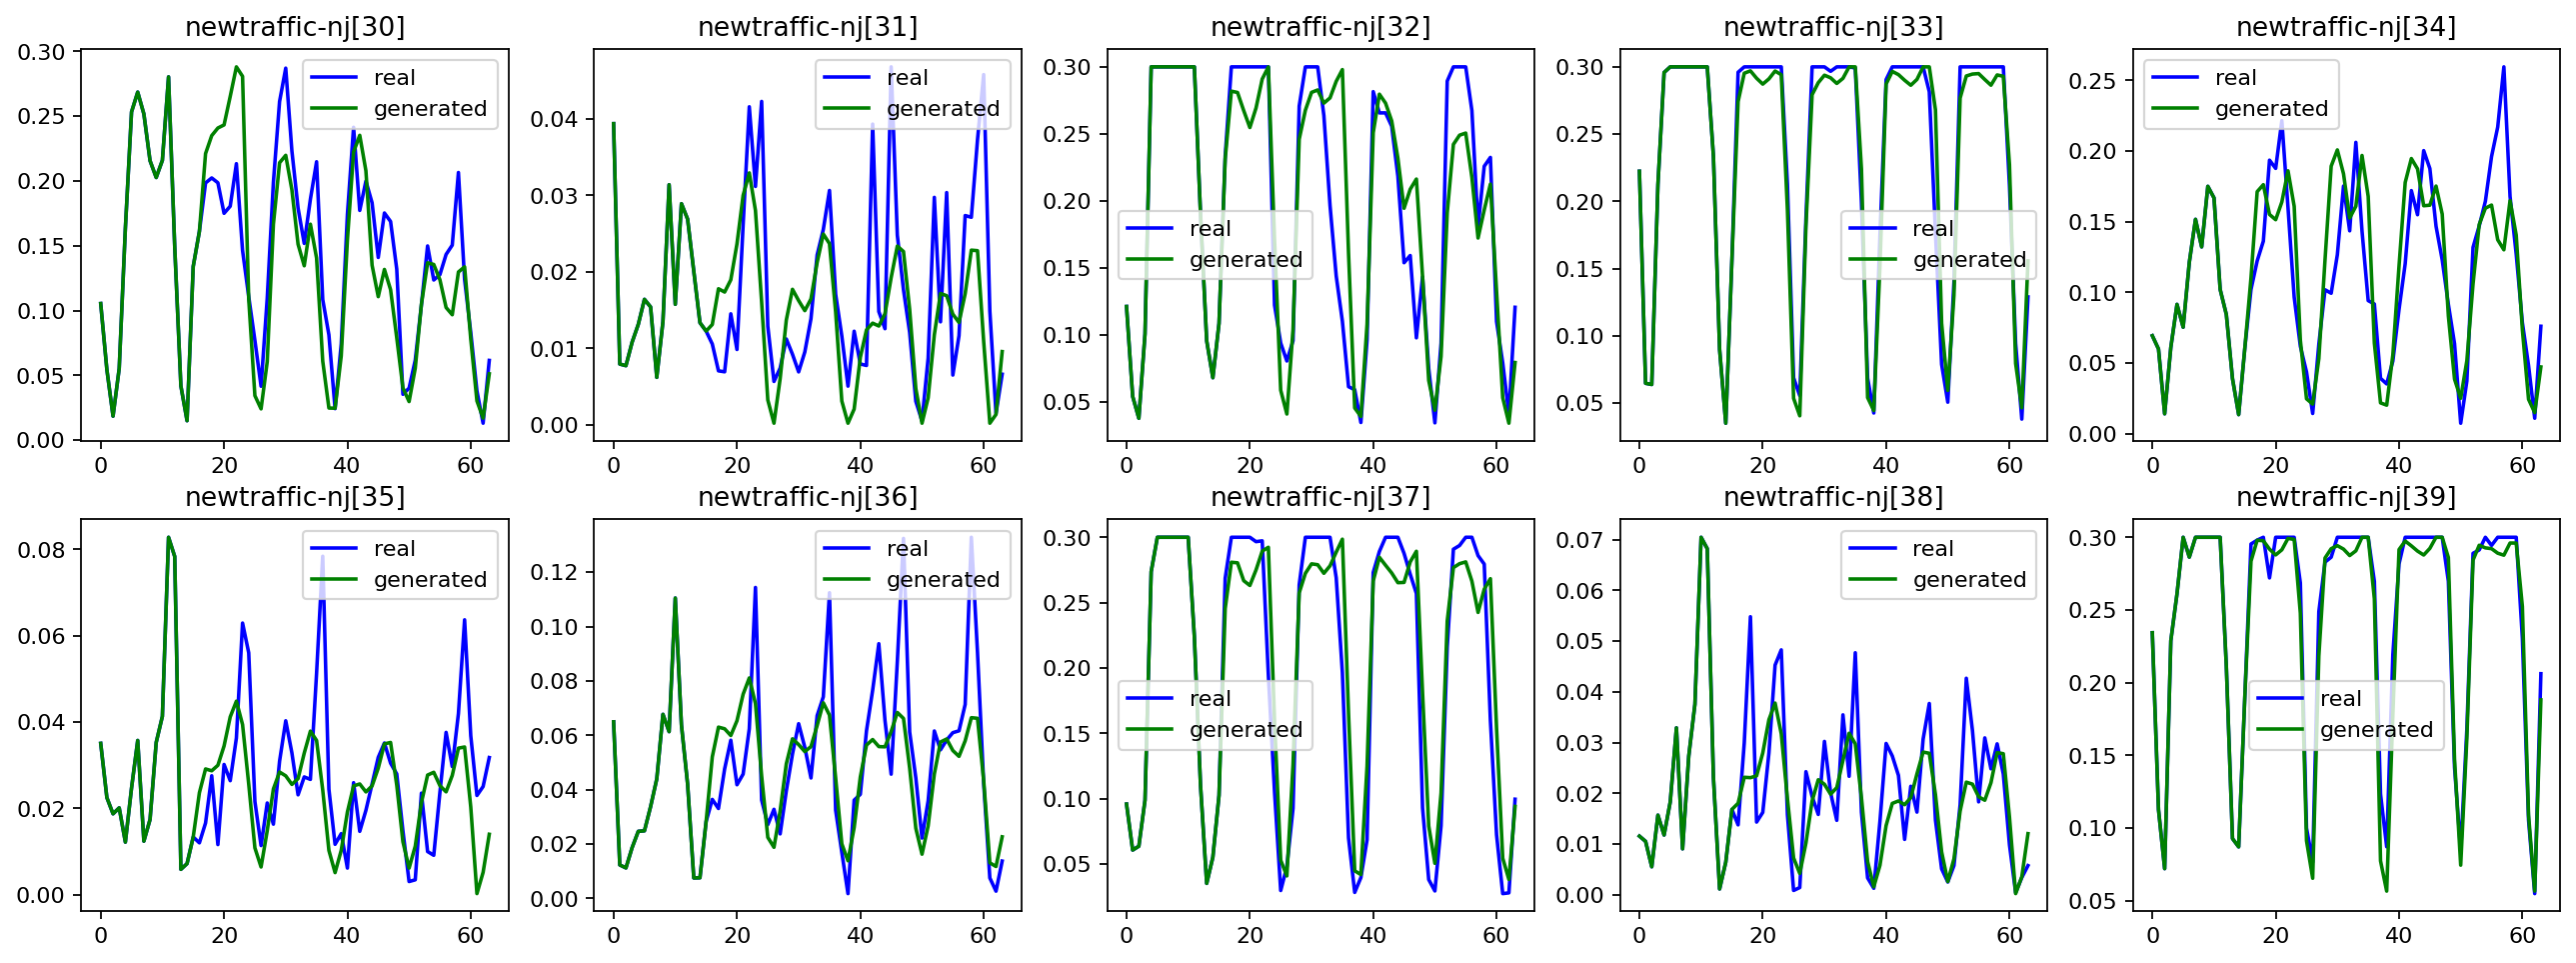

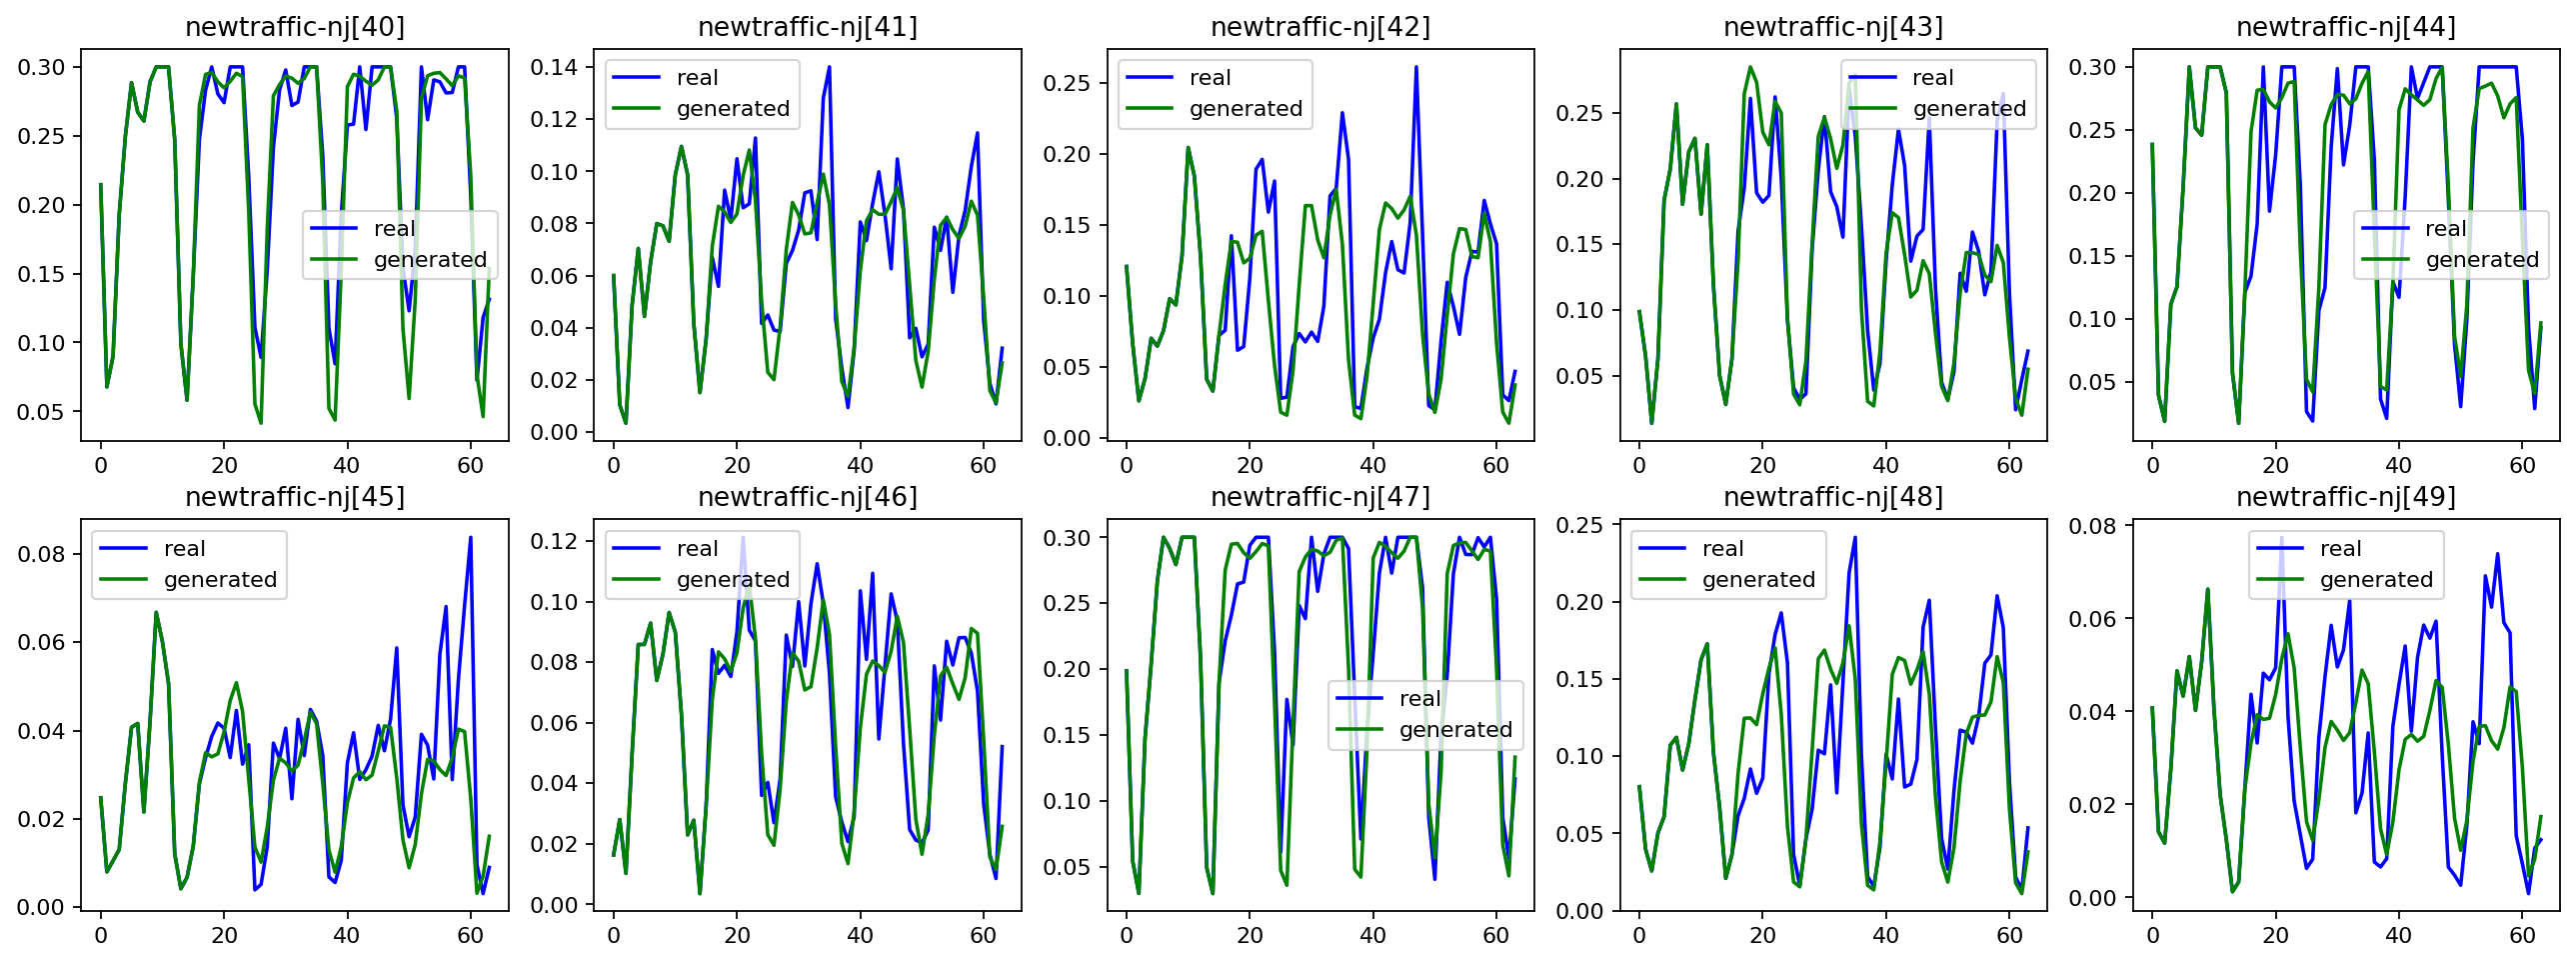

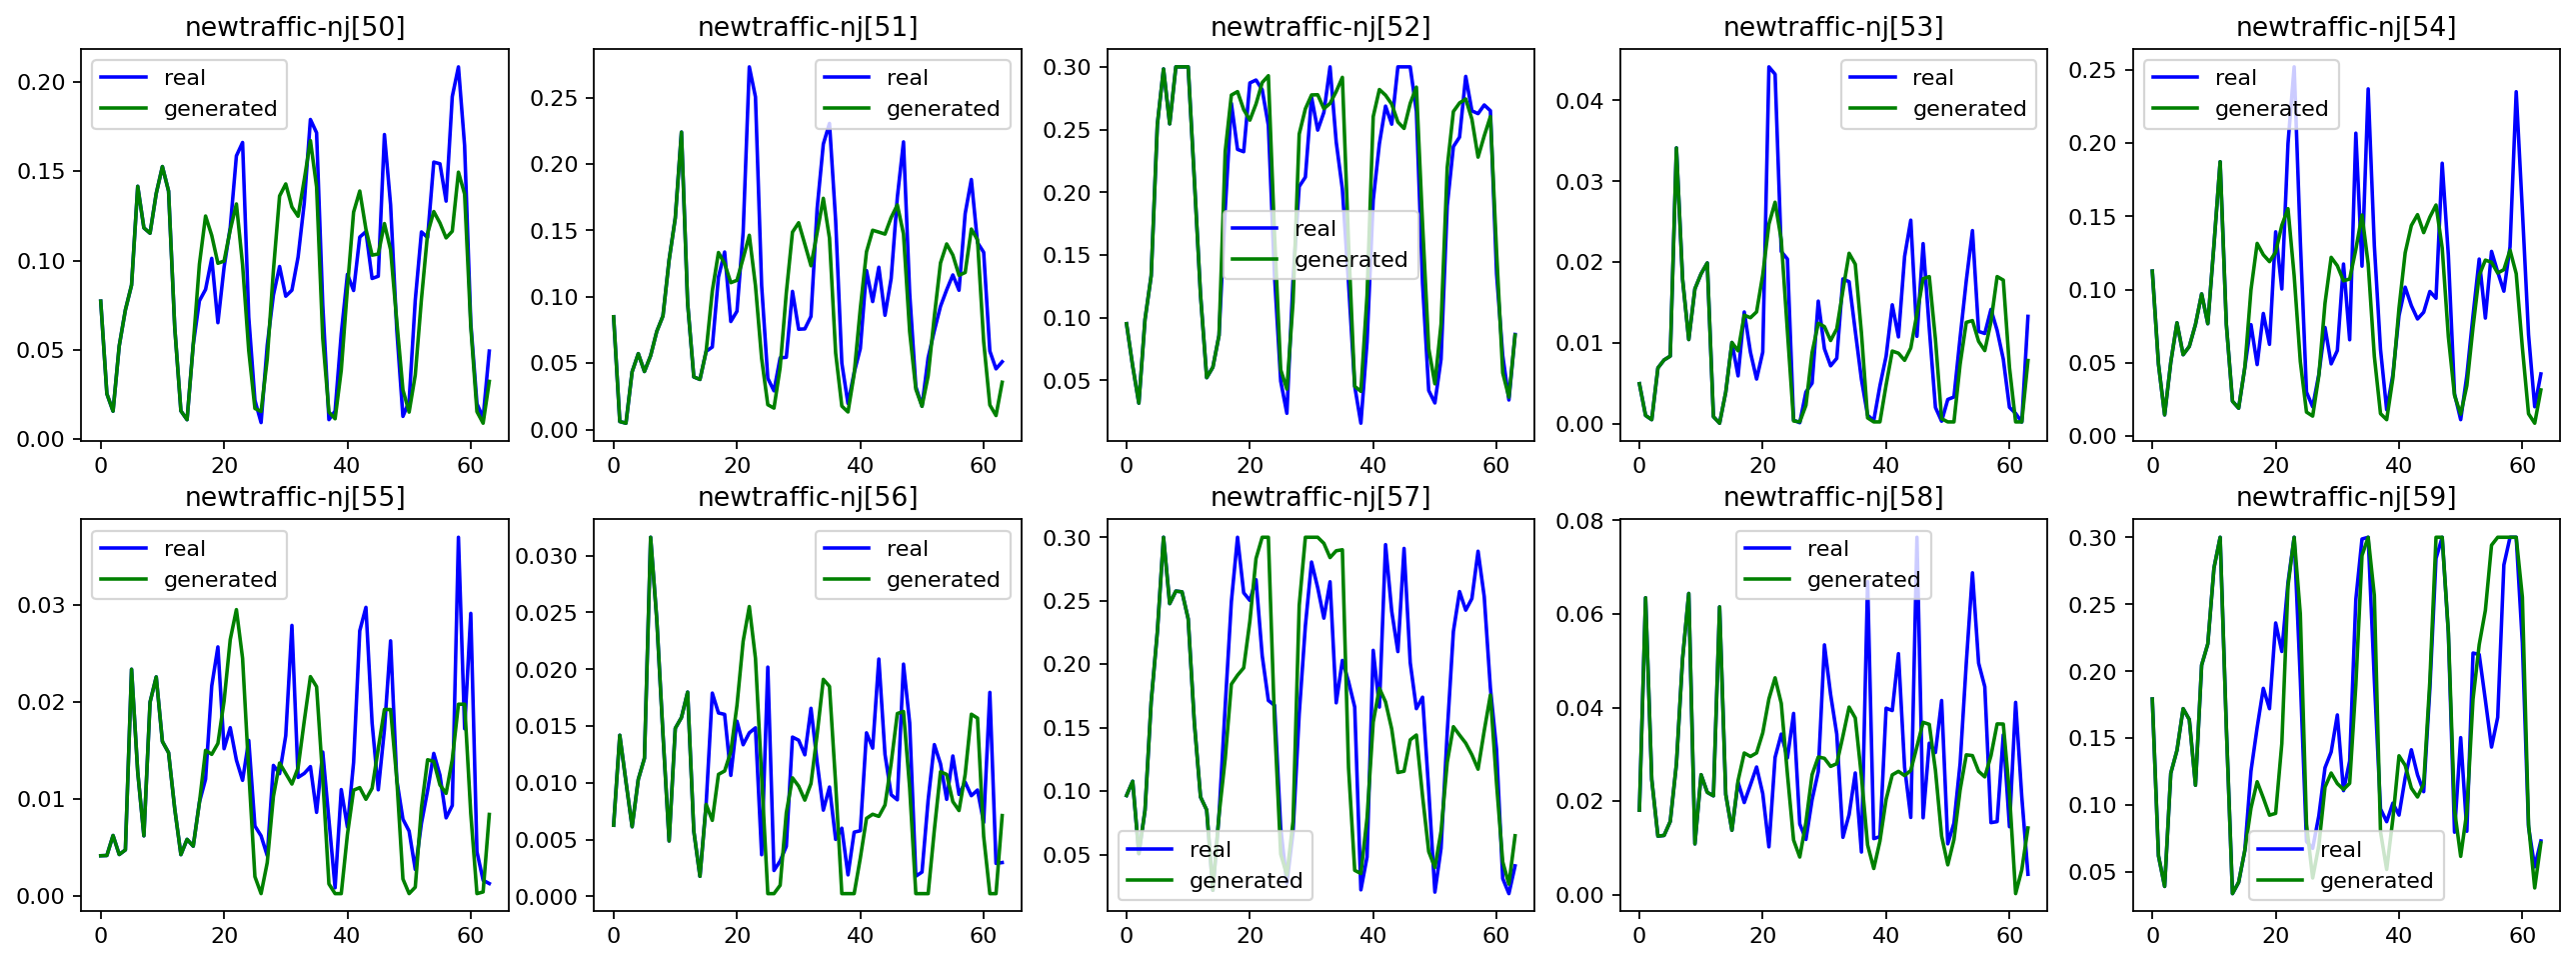

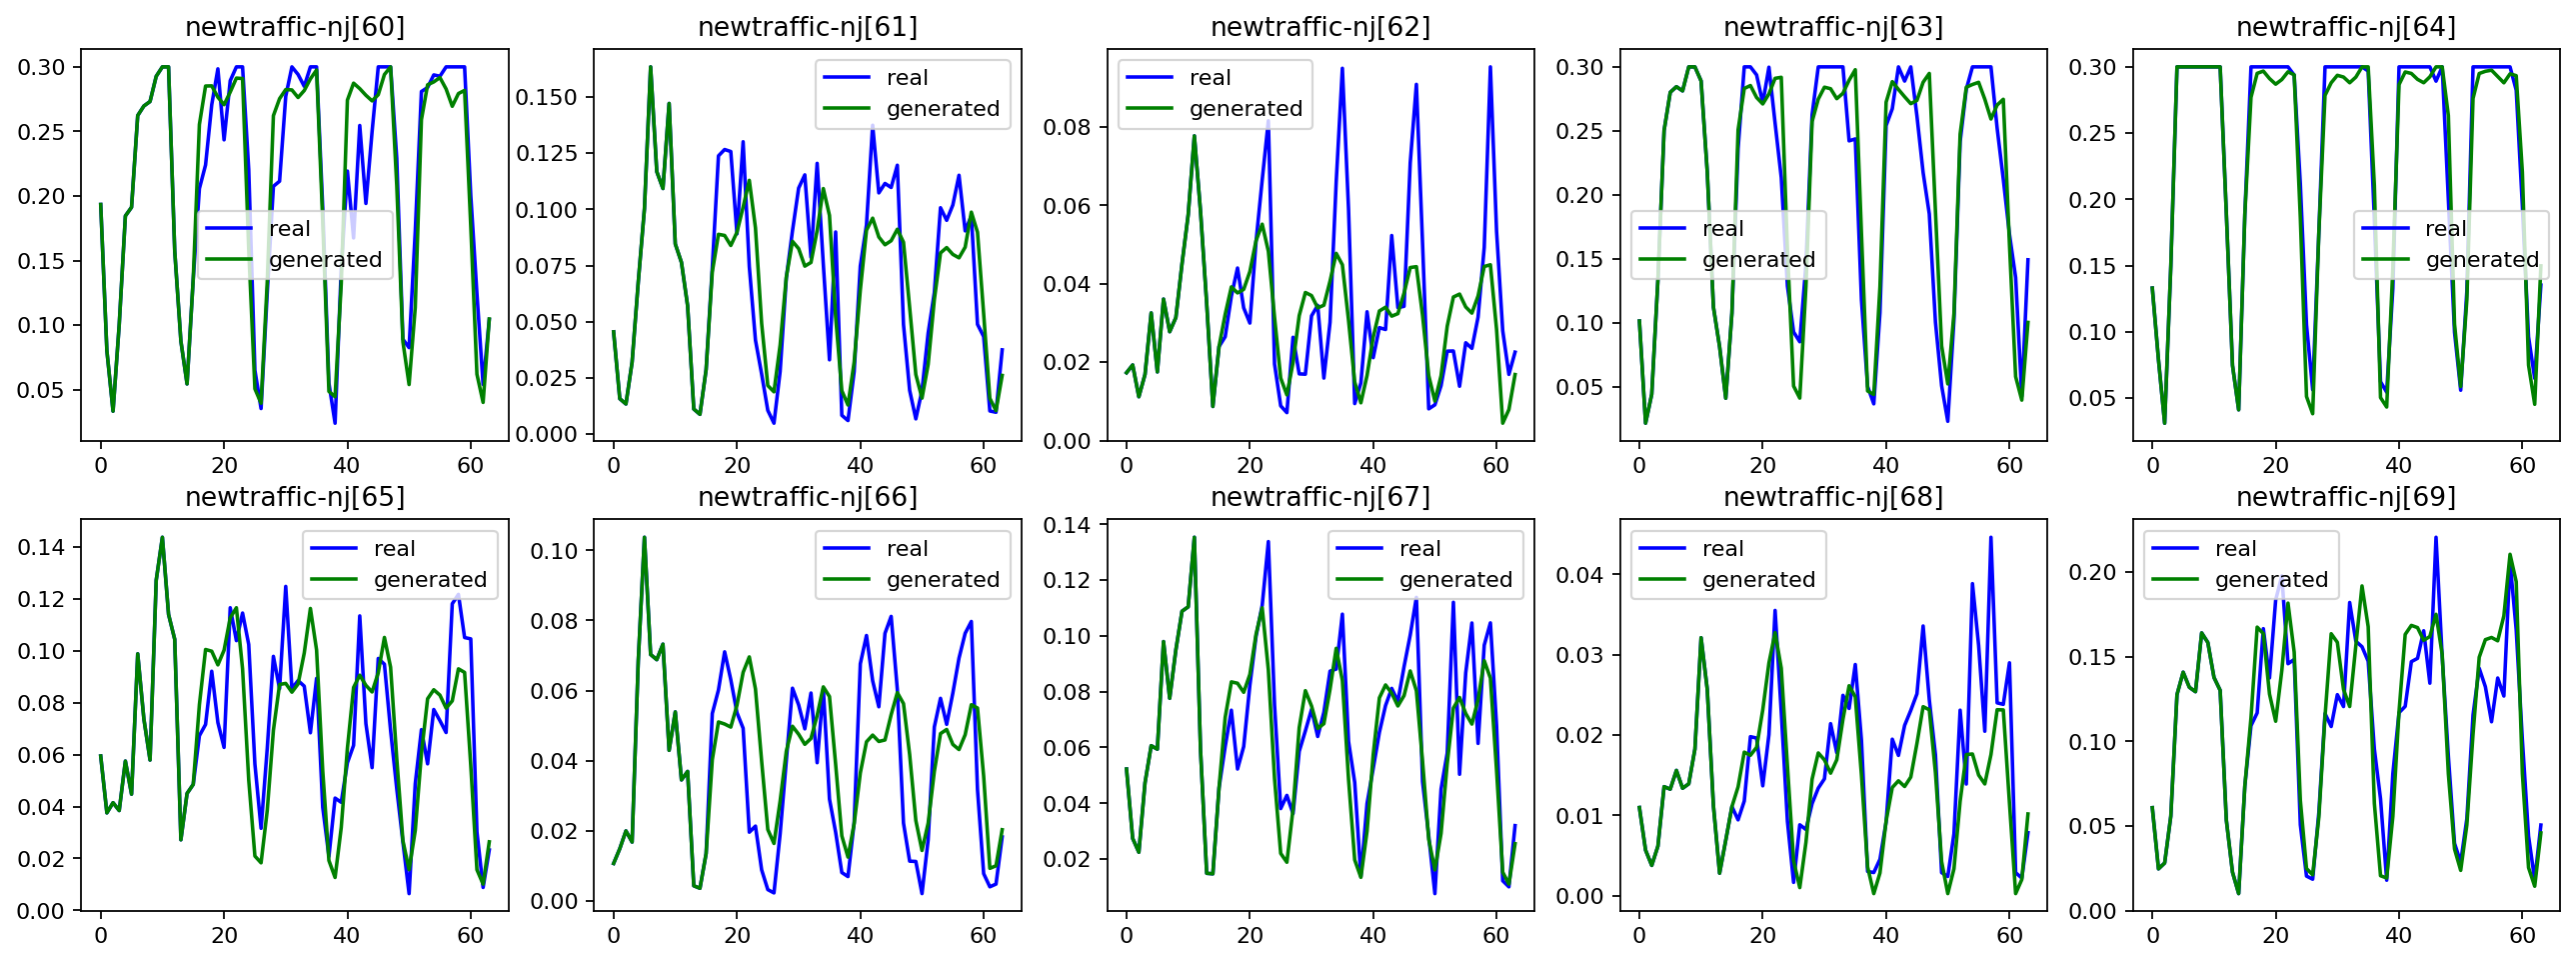

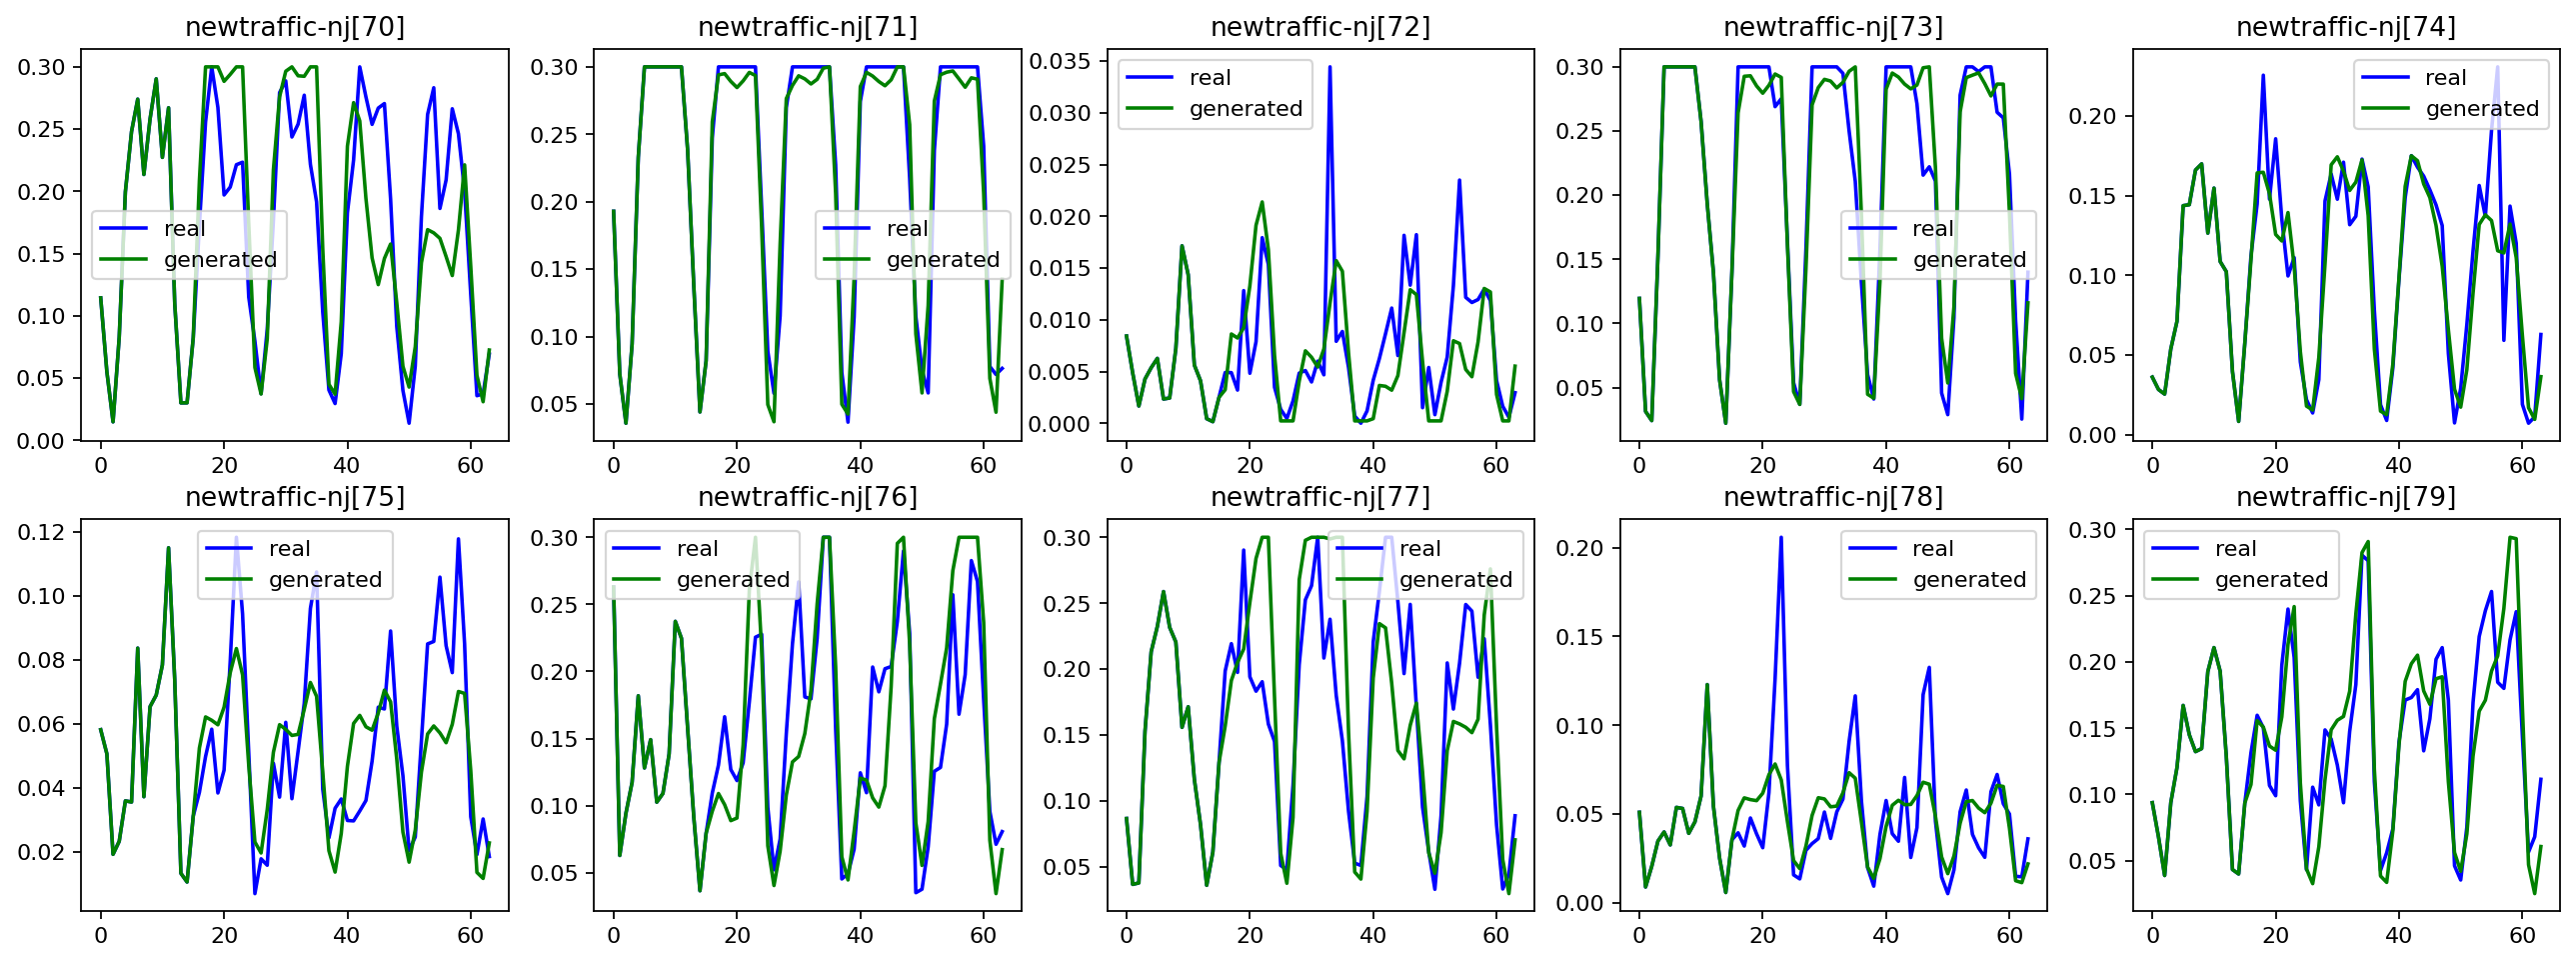

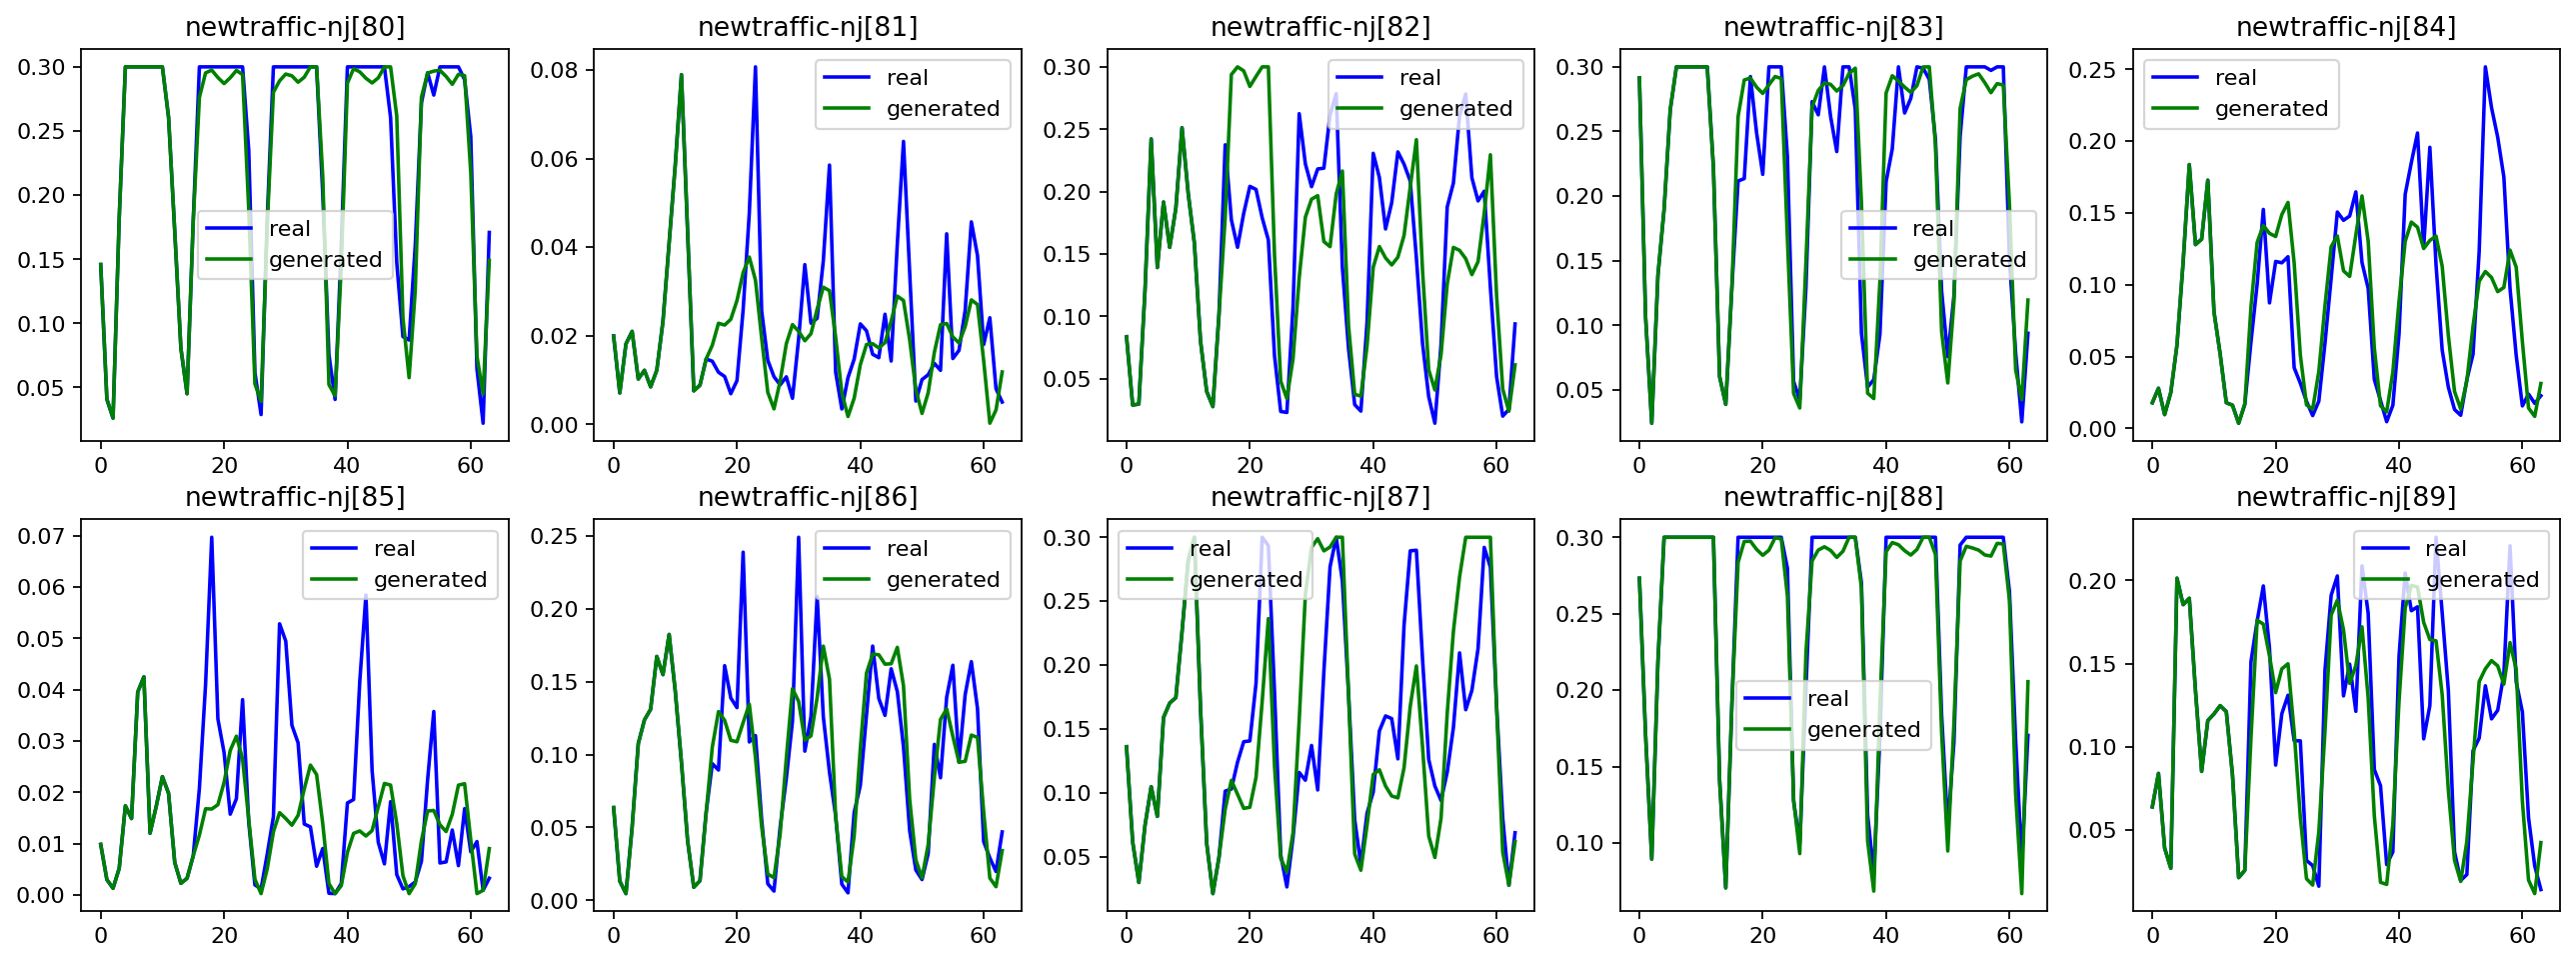

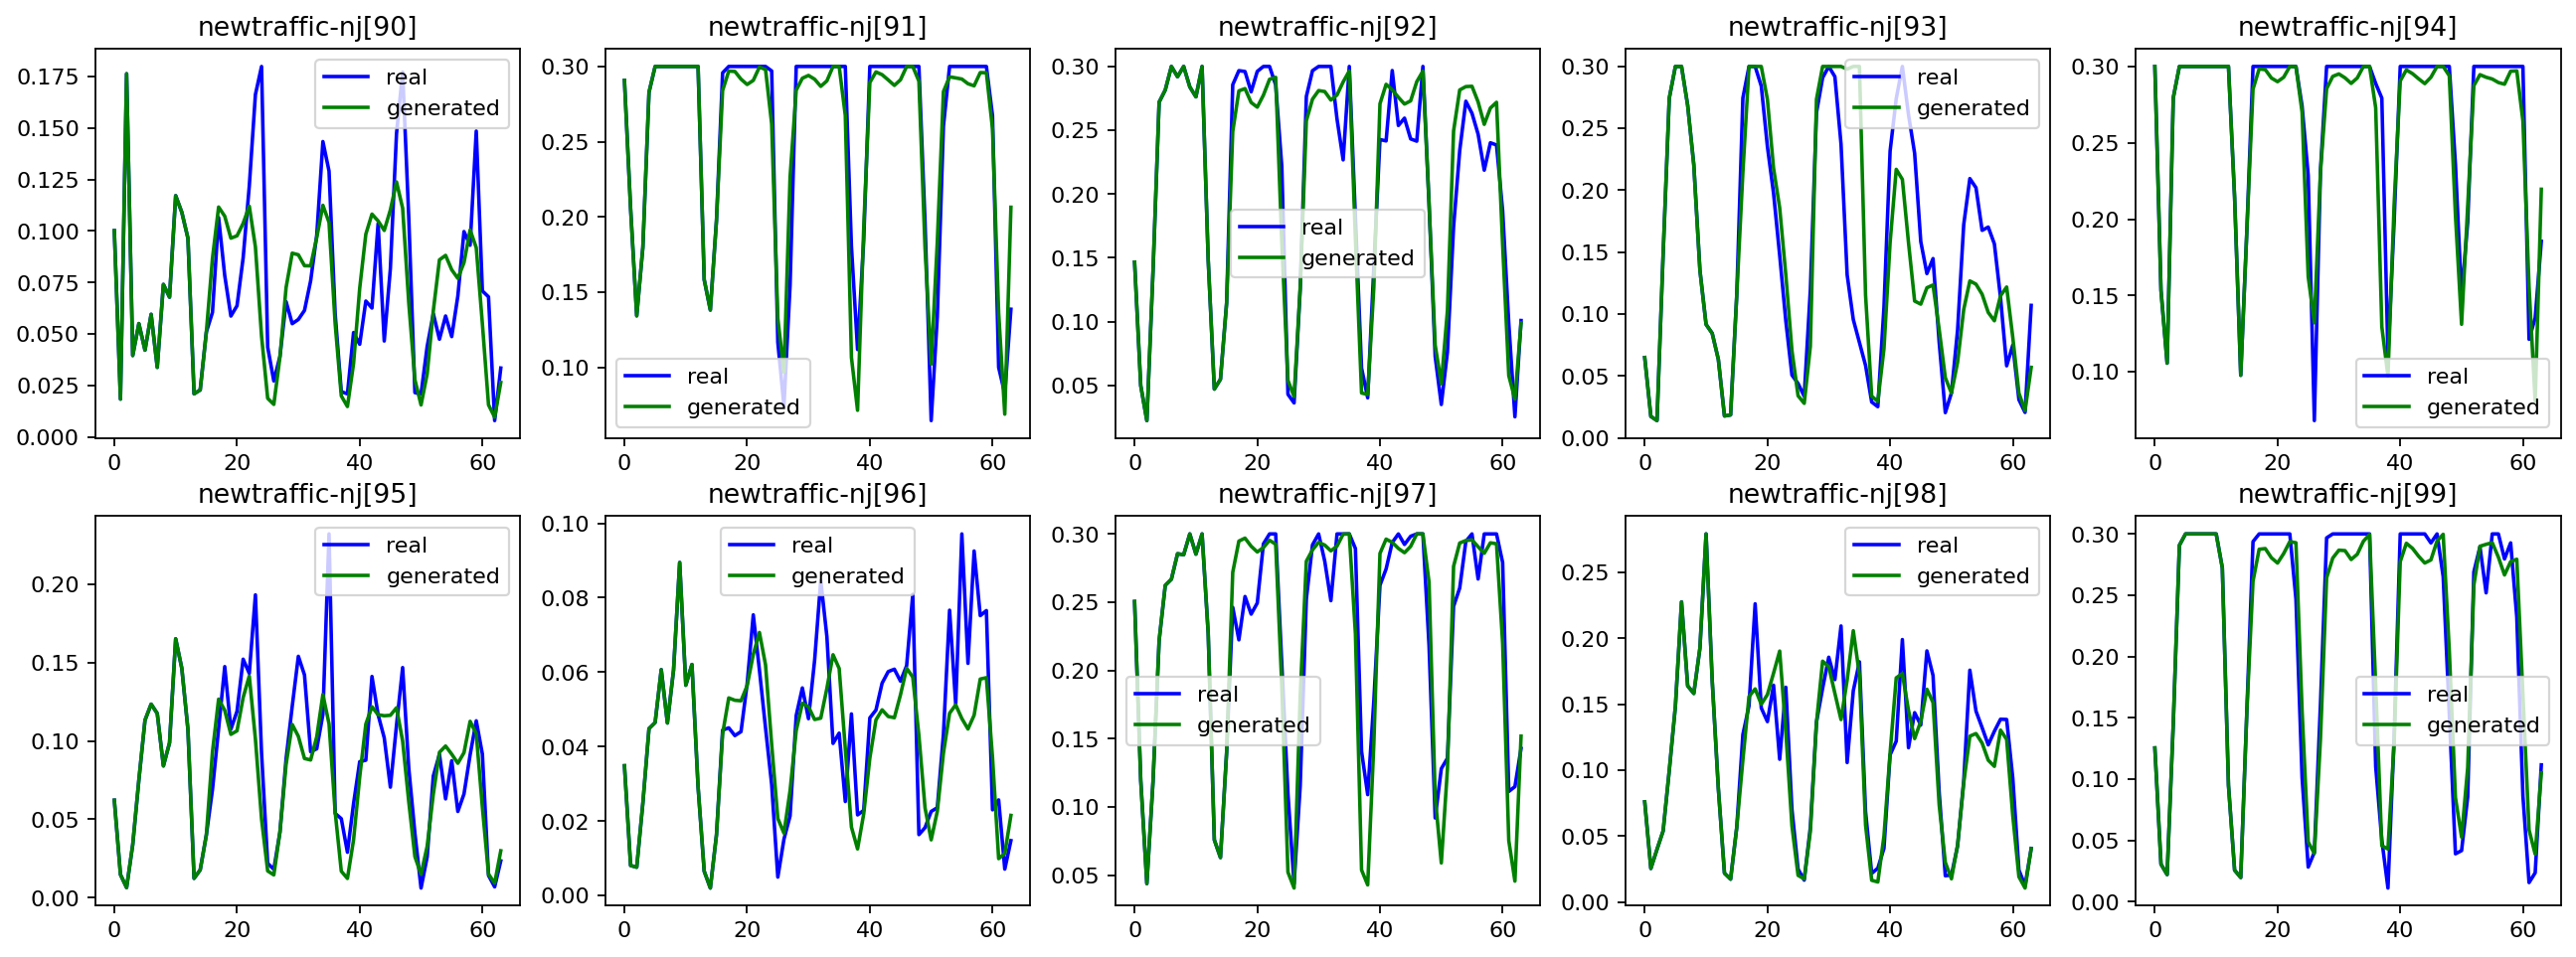

In [18]:
for Add in range(0, 100, 10):

        plt.figure(figsize=(20, 7), dpi=160)
        for i in range(10):
                # Add = 0

                plt.subplot(2, 5, i+1)
                df_target = pd.DataFrame({"x": np.arange(0, L), "val": save_tar[obs][i + Add]})
                plt.plot(df_target.x,
                        df_target.val,
                        color='b',
                        linestyle='solid',
                        label='real',
                        linewidth=1.6)

                df_sample = pd.DataFrame({"x": np.arange(0, L), "val": save_gen[obs][i + Add]})
                plt.plot(df_sample.x,
                        df_sample.val,
                        color='g',
                        linestyle='solid',
                        label='generated',
                        linewidth=1.6)

                # plt.xlabel('time')
                plt.title(typelist[obs] + '[' + str(i + Add) + ']')
                # plt.ylabel('Normalized traffic value')
                # plt.ylabel('Unnormalized value')
                # plt.ylim(0,30)
                plt.legend()

        plt.show()